In [1]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import  max
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import corr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
from google.colab import drive

In [4]:
drive.mount("/drive")

Mounted at /drive


In [5]:
spark = SparkSession.builder.appName("Datos_aerolineas").getOrCreate()

In [6]:
df_aerolineas = spark.read.option("Header", True).csv("/content/Trafico_aereo.csv")
df_aerolineas.show()

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|    

In [7]:
df_aerolineas = df_aerolineas.withColumn("Passenger Count", col("Passenger Count").cast("int"))

In [8]:
aerolineas_distintas = df_aerolineas.select("Operating Airline").distinct().count()
print(aerolineas_distintas)

77


In [9]:
media_pasajeros = df_aerolineas.groupBy('Operating Airline').agg(
    F.avg('Passenger Count').alias('Passanger Count media')
)
media_pasajeros_redondeada = media_pasajeros.withColumn(
    'Passanger Count media',
    F.round('Passanger Count media', 2)
)
media_pasajeros_ordenada = media_pasajeros_redondeada.orderBy('Passanger Count media', ascending=False)
media_pasajeros_ordenada.show()





+--------------------+---------------------+
|   Operating Airline|Passanger Count media|
+--------------------+---------------------+
|   American Airlines|            127164.39|
|  Southwest Airlines|             81188.16|
|      Virgin America|             74405.35|
|     United Airlines|             72732.06|
|     Delta Air Lines|              68498.5|
|          US Airways|             55317.82|
|United Airlines -...|             48915.47|
|    SkyWest Airlines|             37083.84|
|    JetBlue Airways |             35261.14|
|  Northwest Airlines|             26109.25|
|    Compass Airlines|             23358.56|
|Lufthansa German ...|             19301.97|
|         Air Canada |             18251.56|
|   Frontier Airlines|             17787.68|
|     British Airways|             17625.12|
|     Alaska Airlines|             17251.64|
|      Cathay Pacific|             17121.33|
|  Singapore Airlines|             14746.65|
|         EVA Airways|             13116.36|
|         

In [10]:
max_pasajeros = df_aerolineas.groupBy("GEO Region").agg(
    max("Passenger Count").alias("maximo pasajeros")
)


max_pasajeros.show()

+-------------------+----------------+
|         GEO Region|maximo pasajeros|
+-------------------+----------------+
|             Europe|           48136|
|    Central America|            8970|
|                 US|          659837|
|      South America|            3685|
|             Mexico|           29206|
|        Middle East|           14769|
|             Canada|           39798|
|Australia / Oceania|           12973|
|               Asia|           86398|
+-------------------+----------------+



In [11]:
media_pasajeros_csv = "/content/media_pasajeros.csv"
media_pasajeros.write.csv(media_pasajeros_csv, header=True, mode='overwrite')
df_media_pasajeros = spark.read.csv(media_pasajeros_csv, header=True, inferSchema=True)
df_media_pasajeros.show()

+--------------------+---------------------+
|   Operating Airline|Passanger Count media|
+--------------------+---------------------+
|          Icelandair|               2799.7|
|         Ameriflight|                  5.0|
|      Cathay Pacific|   17121.325581395347|
|          Aeromexico|    5463.822222222222|
|      Etihad Airways|    6476.088235294118|
| Philippine Airlines|   10248.635658914729|
|United Airlines -...|    48915.46750232126|
|    Turkish Airlines|    8162.416666666667|
| Swiss International|    6061.640287769784|
|    Independence Air|               6391.3|
|Miami Air Interna...|              107.375|
|          Air France|   11589.077519379845|
|      Japan Airlines|    6470.332046332046|
|    Midwest Airlines|               3883.0|
|      Atlas Air, Inc|                 34.0|
|     JetBlue Airways|    35261.13963963964|
|       China Eastern|    5498.402777777777|
|   Mexicana Airlines|    7993.806451612903|
|          Air Canada|   18251.560109289618|
|       Al

In [12]:
max_pasajeros_csv = "/content/max_pasajeros.csv"
max_pasajeros.coalesce(1).write.csv(max_pasajeros_csv, header=True, mode='overwrite')
df_max_pasajeros = spark.read.csv(max_pasajeros_csv, header=True, inferSchema=True)
df_max_pasajeros.show()

+-------------------+----------------+
|         GEO Region|maximo pasajeros|
+-------------------+----------------+
|             Europe|           48136|
|    Central America|            8970|
|                 US|          659837|
|      South America|            3685|
|             Mexico|           29206|
|        Middle East|           14769|
|             Canada|           39798|
|Australia / Oceania|           12973|
|               Asia|           86398|
+-------------------+----------------+



In [13]:
datos_limpios = df_aerolineas.withColumn(
    "mes",
    F.when(F.col("Month") == "January", 1)
     .when(F.col("Month") == "February", 2)
     .when(F.col("Month") == "March", 3)
     .when(F.col("Month") == "April", 4)
     .when(F.col("Month") == "May", 5)
     .when(F.col("Month") == "June", 6)
     .when(F.col("Month") == "July", 7)
     .when(F.col("Month") == "August", 8)
     .when(F.col("Month") == "September", 9)
     .when(F.col("Month") == "October", 10)
     .when(F.col("Month") == "November", 11)
     .when(F.col("Month") == "December", 12))
datos_limpios = datos_limpios.withColumn("mes", F.col("mes").cast("integer"))
datos_limpios.show()

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+---+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|mes|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+---+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     D

In [14]:
datos_ano_mes = datos_limpios.groupBy('mes') \
    .agg(F.mean('Passenger Count').alias('Media_pasajeros_mes')) \
    .orderBy('mes')

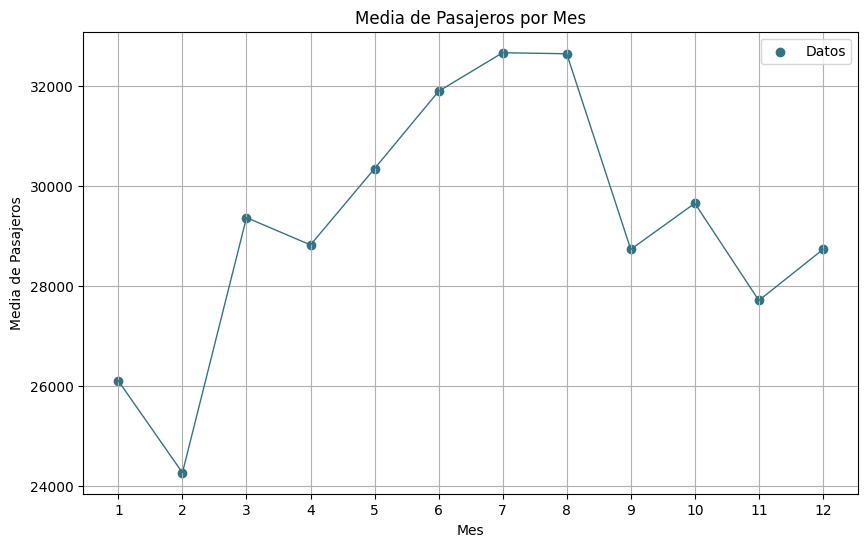

In [15]:
datos_ano_mes_pd = datos_ano_mes.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(datos_ano_mes_pd['mes'], datos_ano_mes_pd['Media_pasajeros_mes'], color='#347383', label='Datos')
plt.plot(datos_ano_mes_pd['mes'], datos_ano_mes_pd['Media_pasajeros_mes'], color='#347383', linewidth=1)
plt.title('Media de Pasajeros por Mes')
plt.xlabel('Mes')
plt.ylabel('Media de Pasajeros')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.show()

In [16]:
datos_aerolinea = datos_limpios.groupBy('Operating Airline', 'mes') \
    .agg(F.mean('Passenger Count').alias('Media_pasajeros_mes_aerolinea')) \
    .orderBy('mes')

In [17]:
datos_aerolinea_ano = datos_limpios.groupBy('Year', 'Operating Airline') \
    .agg(F.mean('Passenger Count').alias('Media_pasajeros_ano_aerolinea')) \
    .orderBy('Year')

In [18]:
datos_limpios = datos_limpios.withColumnRenamed("GEO Region", "GEO_Region")
datos_limpios = datos_limpios.withColumnRenamed("Passenger Count", "Cantidad_pasajeros")
datos_limpios = datos_limpios.withColumnRenamed("GEO Summary", "GEO_Summary")
datos_limpios = datos_limpios.withColumnRenamed("Operating Airline", "Operating_Airline")

In [19]:
datos_limpios = datos_limpios.withColumn(
    "hemisferio",
    F.when(
        (F.col("GEO_Region").isin("Asia", "Canada", "US", "Europe")), "Norte"
    ).when(
        (F.col("GEO_Region").isin("Australia / Oceania", "South America")), "Sur"
    ).when(
        (F.col("GEO_Region").isin("Central America", "Middle East", "Mexico")), "Centro"
    ).otherwise(None)
)

datos_limpios = datos_limpios.withColumn(
    "Region",
    F.when(
        (F.col("GEO_Region").isin("US")), 1
    ).when(
        (F.col("GEO_Region").isin("Canada")), 2
    ).when(
        (F.col("GEO_Region").isin("Europe")), 3
    ).when(
        (F.col("GEO_Region").isin("Australia / Oceania")), 4
    ).when(
        (F.col("GEO_Region").isin("Mexico")), 5
    ).when(
        (F.col("GEO_Region").isin("South America")), 6
    ).when(
        (F.col("GEO_Region").isin("Asia")), 7
    ).when(
        (F.col("GEO_Region").isin("Middle East")), 8
    ).when(
        (F.col("GEO_Region").isin("Central America")), 9
    ).otherwise(None) )

datos_limpios.show()

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+------------------+---------------------------+------------------------+----+-----+---+----------+------+
|Activity Period|Operating_Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO_Summary|         GEO_Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Cantidad_pasajeros|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|mes|hemisferio|Region|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+------------------+---------------------------+------------------------+----+-----+---+----------+------+
|         200507|     ATA Airlines|                 

In [20]:
datos_limpios_pandas = datos_limpios.toPandas()

# Ajustar el modelo OLS con la fórmula correcta
model = ols('Cantidad_pasajeros ~ C(mes)', data=datos_limpios_pandas).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq       df         F   PR(>F)
C(mes)    8.782709e+10     11.0  2.349836  0.00687
Residual  5.095006e+13  14995.0       NaN      NaN


In [21]:
resultado = datos_limpios.groupBy("GEO_Region").agg(
    F.avg("Cantidad_pasajeros").alias("media_pasajeros")
)
resultado.show()

+-------------------+------------------+
|         GEO_Region|   media_pasajeros|
+-------------------+------------------+
|             Europe|12755.652465294399|
|    Central America| 4946.715328467153|
|                 US| 58330.34345351044|
|      South America| 2786.011111111111|
|             Mexico|  7173.62062780269|
|        Middle East|  8658.61214953271|
|             Canada|   9777.9682651622|
|Australia / Oceania| 6417.016282225238|
|               Asia| 13435.00458295142|
+-------------------+------------------+



In [22]:
resultado = datos_limpios.groupBy("Price Category Code").agg(
    F.avg("Cantidad_pasajeros").alias("media_pasajeros")
)
resultado = resultado.orderBy("media_pasajeros", ascending=True)
resultado.show()

+-------------------+------------------+
|Price Category Code|   media_pasajeros|
+-------------------+------------------+
|              Other|27787.546114464734|
|           Low Fare| 39144.21041666667|
+-------------------+------------------+



In [23]:
resultado = datos_limpios.groupBy("Year").agg(
    F.avg("Cantidad_pasajeros").alias("media_pasajeros")
)
resultado = resultado.orderBy("media_pasajeros", ascending=True)
resultado.show()

+----+------------------+
|Year|   media_pasajeros|
+----+------------------+
|2006|24348.407596785975|
|2005|24779.903597122302|
|2007| 25233.55713271824|
|2008| 25983.72505233775|
|2009|26804.696338837042|
|2010|28383.224150397687|
|2011| 29444.45035971223|
|2016|30808.212938005392|
|2012|32220.526124818578|
|2013| 33097.02503681885|
|2015| 34286.22397260274|
|2014| 34440.51973684211|
+----+------------------+



In [24]:
resultado = datos_limpios.groupBy("Month").agg(
    F.avg("Cantidad_pasajeros").alias("media_pasajeros")
)
resultado = resultado.orderBy("media_pasajeros", ascending=True)
resultado.show()

+---------+------------------+
|    Month|   media_pasajeros|
+---------+------------------+
| February| 24258.40796812749|
|  January| 26094.37066246057|
| November|27702.751385589865|
| December|28723.198570293884|
|September|28725.348496530456|
|    April|28813.577893820715|
|    March|29359.807661612133|
|  October|29645.857915057913|
|      May|30340.417235494882|
|     June|31886.650887573964|
|   August|32636.380916030535|
|     July|32657.033768227167|
+---------+------------------+



In [25]:
resultado = datos_limpios.groupBy("GEO_Summary").agg(
    F.avg("Cantidad_pasajeros").alias("media_pasajeros")
)
resultado = resultado.orderBy("media_pasajeros", ascending=True)
resultado.show()

+-------------+------------------+
|  GEO_Summary|   media_pasajeros|
+-------------+------------------+
|International|10930.673072747015|
|     Domestic| 58330.34345351044|
+-------------+------------------+



In [26]:
resultado = datos_limpios.groupBy("GEO_Summary").agg(
    F.stddev("Cantidad_pasajeros").alias("media_pasajeros")
)
resultado = resultado.orderBy("media_pasajeros", ascending=True)
resultado.show()

+-------------+------------------+
|  GEO_Summary|   media_pasajeros|
+-------------+------------------+
|International|11493.706383971215|
|     Domestic| 84951.31664013123|
+-------------+------------------+



In [27]:
resultado = datos_limpios.groupBy("GEO_Region").agg(
    F.stddev("Cantidad_pasajeros").alias("desv_pasajeros")
)
resultado = resultado.orderBy("desv_pasajeros", ascending=True)
resultado.show()

+-------------------+------------------+
|         GEO_Region|    desv_pasajeros|
+-------------------+------------------+
|      South America| 396.7586506195526|
|    Central America|1220.8403125914656|
|        Middle East|   2732.7195183986|
|Australia / Oceania|2799.8406500183883|
|             Mexico| 5336.223001980255|
|             Canada| 7833.110588404248|
|             Europe| 8634.076411562175|
|               Asia|16188.148775860833|
|                 US| 84951.31664013123|
+-------------------+------------------+



In [28]:
resultado = datos_limpios.groupBy("Month").agg(
    F.stddev("Cantidad_pasajeros").alias("desv_pasajeros")
)
resultado = resultado.orderBy("desv_pasajeros", ascending=True)
resultado.show()

+---------+------------------+
|    Month|    desv_pasajeros|
+---------+------------------+
| February|  47569.0069987234|
|  January| 51294.88007998184|
| November|56175.549821247325|
|    April|56293.933065065205|
|    March|57519.653386710845|
| December| 57566.02013447425|
|September| 58236.29488536921|
|      May| 59000.17436267259|
|  October| 60490.12293144308|
|     June|61424.496549347394|
|     July|65309.479556884944|
|   August| 65568.50655076625|
+---------+------------------+



In [29]:
resultado = datos_limpios.groupBy("Year").agg(
    F.stddev("Cantidad_pasajeros").alias("desv_pasajeros")
)
resultado = resultado.orderBy("desv_pasajeros", ascending=True)
resultado.show()

+----+------------------+
|Year|    desv_pasajeros|
+----+------------------+
|2008|  50774.2273603889|
|2007|52686.333022728555|
|2006| 53418.13826968551|
|2005| 54774.38414321783|
|2009| 55096.04274953367|
|2016|56351.917740411474|
|2010|  57782.3443543718|
|2011|57938.886803724185|
|2012|58612.368565066805|
|2015|62735.130892386165|
|2014| 63694.36786274649|
|2013| 69500.20489950952|
+----+------------------+



In [30]:
resultado = datos_limpios.groupBy("Operating_Airline").agg(
    F.mean("Cantidad_pasajeros").alias("media_pasajeros")
)
resultado = resultado.orderBy("media_pasajeros", ascending=True)
resultado_filtrado = resultado.filter(
    (F.col("media_pasajeros").isNotNull()) & (F.col("media_pasajeros") != 0.0)
)
resultado_filtrado.show()

+--------------------+------------------+
|   Operating_Airline|   media_pasajeros|
+--------------------+------------------+
|Evergreen Interna...|               2.0|
|         Ameriflight|               5.0|
|      Boeing Company|              18.0|
|      Atlas Air, Inc|              34.0|
|        Xtra Airways|              73.0|
|           Servisair| 90.05555555555556|
|Miami Air Interna...|           107.375|
|    Pacific Aviation|             160.0|
|       Swissport USA|             258.6|
|       World Airways| 261.6666666666667|
|     Air Canada Jazz| 294.2142857142857|
|     BelAir Airlines| 415.3636363636364|
|       Allegiant Air|         1516.8125|
|Atlantic Southeas...| 2176.909090909091|
|   XL Airways France|2223.1612903225805|
|          Air Berlin|           2320.75|
|   Republic Airlines|            2452.5|
|            LAN Peru| 2786.011111111111|
|          Icelandair|            2799.7|
|   Air India Limited|            2834.5|
+--------------------+------------

In [31]:
resultado = datos_limpios.groupBy("Operating_Airline").agg(
    F.stddev("Cantidad_pasajeros").alias("desv_pasajeros")
)
resultado = resultado.orderBy("desv_pasajeros", ascending=True)
resultado_filtrado = resultado.filter(
    (F.col("desv_pasajeros").isNotNull()) & (F.col("desv_pasajeros") != 0.0)
)
resultado_filtrado.show()

+--------------------+------------------+
|   Operating_Airline|    desv_pasajeros|
+--------------------+------------------+
|         Ameriflight| 2.811540841738193|
|       World Airways|  8.32666399786453|
|      Atlas Air, Inc|43.840620433565945|
|Miami Air Interna...|57.147615873280316|
|           Servisair| 58.46461417910078|
|       Swissport USA|108.63161865418637|
|     Air Canada Jazz|123.74612881057895|
|       Allegiant Air|   296.28594718616|
|     BelAir Airlines|  307.386920044947|
|   Air India Limited|332.53657156555187|
|            LAN Peru| 396.7586506195526|
|  All Nippon Airways| 729.6152772279747|
|          Air Berlin| 752.8463464934738|
|Atlantic Southeas...| 805.7488034115435|
| COPA Airlines, Inc.| 925.0276889232697|
|American Eagle Ai...| 972.0801476612352|
| Swiss International|1010.2268937797376|
|       China Eastern|1106.9863754740318|
|                TACA|1107.0208081703788|
|     Spirit Airlines|1139.3293022905937|
+--------------------+------------

In [32]:
datos_limpios_pandas = datos_limpios.toPandas()
modelo = ols('Cantidad_pasajeros ~ C(GEO_Region)', data=datos_limpios_pandas).fit()
anova_resultado = sm.stats.anova_lm(modelo, typ=2)
print(anova_resultado)

                     sum_sq       df           F  PR(>F)
C(GEO_Region)  8.070191e+12      8.0  352.115472     0.0
Residual       4.296769e+13  14998.0         NaN     NaN


In [33]:
datos_limpios_pandas = datos_limpios.toPandas()
modelo = ols('Cantidad_pasajeros ~ C(Year)', data=datos_limpios_pandas).fit()
anova_resultado = sm.stats.anova_lm(modelo, typ=2)
print(anova_resultado)

                sum_sq       df         F        PR(>F)
C(Year)   2.012608e+11     11.0  5.396799  1.269124e-08
Residual  5.083662e+13  14995.0       NaN           NaN


In [34]:
datos_limpios_pandas = datos_limpios.toPandas()
modelo = ols('Cantidad_pasajeros ~ C(Operating_Airline)', data=datos_limpios_pandas).fit()
anova_resultado = sm.stats.anova_lm(modelo, typ=2)
print(anova_resultado)

                            sum_sq       df          F  PR(>F)
C(Operating_Airline)  1.113477e+13     76.0  54.817709     0.0
Residual              3.990311e+13  14930.0        NaN     NaN


In [35]:
datos_limpios_pandas = datos_limpios.toPandas()
modelo = ols('Cantidad_pasajeros ~ C(mes)', data=datos_limpios_pandas).fit()
anova_resultado = sm.stats.anova_lm(modelo, typ=2)
print(anova_resultado)

                sum_sq       df         F   PR(>F)
C(mes)    8.782709e+10     11.0  2.349836  0.00687
Residual  5.095006e+13  14995.0       NaN      NaN


In [36]:
datos_limpios = datos_limpios.withColumn("label_pasajeros",
                   when(col("Cantidad_pasajeros") < 1000, 0)
                   .when((col("Cantidad_pasajeros") >= 1000) & (col("Cantidad_pasajeros") < 5000), 1)
                   .when((col("Cantidad_pasajeros") >= 5000) & (col("Cantidad_pasajeros") < 10000), 2)
                   .when((col("Cantidad_pasajeros") >= 10000) & (col("Cantidad_pasajeros") < 15000), 3)
                   .otherwise(4))

In [37]:
datos_limpios.write.mode("overwrite").csv('/content/datos_limpios', header=True)

In [38]:
df = spark.read.csv('/content/datos_limpios', header=True, inferSchema=True)
airline_indexer = StringIndexer(inputCol="Operating_Airline", outputCol="airline_indexed")
terminal_indexer = StringIndexer(inputCol="Terminal", outputCol="terminal_indexed")
summary_indexer = StringIndexer(inputCol="GEO_Summary", outputCol="summary_indexed")
price_indexer = StringIndexer(inputCol="Price Category Code", outputCol="price_indexed")

df = airline_indexer.fit(df).transform(df)
df = terminal_indexer.fit(df).transform(df)
df = summary_indexer.fit(df).transform(df)
df = price_indexer.fit(df).transform(df)

assembler = VectorAssembler(inputCols=["Region", "Year", "mes", "airline_indexed", "summary_indexed"], outputCol="features")


dt_classifier = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="label_pasajeros",
    maxBins=80,
    maxDepth=30,
    minInstancesPerNode=10
)

pipeline = Pipeline(stages=[assembler, dt_classifier])

train, test = df.randomSplit([0.7, 0.3], seed=1234)

model = pipeline.fit(train)

predictions = model.transform(test)

predictions.select("features", "Cantidad_pasajeros", "probability", "prediction", "label_pasajeros").show()

+--------------------+------------------+--------------------+----------+---------------+
|            features|Cantidad_pasajeros|         probability|prediction|label_pasajeros|
+--------------------+------------------+--------------------+----------+---------------+
|[1.0,2005.0,7.0,4...|             27271|[0.3,0.1,0.1,0.05...|       4.0|              4|
|[1.0,2005.0,7.0,4...|             29131|[0.3,0.1,0.1,0.05...|       4.0|              4|
|[2.0,2005.0,7.0,5...|             34090|[0.0,0.0,0.0,0.04...|       4.0|              4|
|[7.0,2005.0,7.0,1...|              6545|[0.0,0.0,1.0,0.0,...|       2.0|              2|
|[1.0,2005.0,7.0,9...|            160890|[0.0,0.0,0.0,0.0,...|       4.0|              4|
|[1.0,2005.0,7.0,4...|              5493|[0.0,0.36,0.48,0....|       2.0|              2|
|[1.0,2005.0,7.0,4...|              5213|[0.0,0.36,0.48,0....|       2.0|              2|
|[7.0,2005.0,7.0,1...|              5041|[0.0,0.8571428571...|       1.0|              2|
|[1.0,2005

In [39]:

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_pasajeros",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.26%


In [40]:

airline_indexer = StringIndexer(inputCol="Operating_Airline", outputCol="airline_indexed")
terminal_indexer = StringIndexer(inputCol="Terminal", outputCol="terminal_indexed")
summary_indexer = StringIndexer(inputCol="GEO_Summary", outputCol="summary_indexed")
price_indexer = StringIndexer(inputCol="Price Category Code", outputCol="price_indexed")

assembler = VectorAssembler(inputCols=["Region", "Year", "mes", "airline_indexed", "summary_indexed"], outputCol="features")

rf_classifier = RandomForestClassifier(
    featuresCol="features",
    labelCol="label_pasajeros",
    numTrees=100,
    maxDepth=30,
    minInstancesPerNode=5,
    maxBins=80
)

pipeline = Pipeline(stages=[assembler, rf_classifier])

train, test = df.randomSplit([0.8, 0.2], seed=1234)

model = pipeline.fit(train)

predictions = model.transform(test)

predictions.select("features", "Cantidad_pasajeros", "probability", "prediction", "label_pasajeros").show()

+--------------------+------------------+--------------------+----------+---------------+
|            features|Cantidad_pasajeros|         probability|prediction|label_pasajeros|
+--------------------+------------------+--------------------+----------+---------------+
|[1.0,2005.0,7.0,4...|             29131|[0.11122560750618...|       4.0|              4|
|[2.0,2005.0,7.0,5...|             34090|[1.21951219512195...|       4.0|              4|
|[7.0,2005.0,7.0,1...|              6545|[0.00342752891029...|       2.0|              2|
|[1.0,2005.0,7.0,9...|            160890|[2.27272727272727...|       4.0|              4|
|[1.0,2005.0,7.0,4...|              5493|[0.01669781958689...|       1.0|              2|
|[1.0,2005.0,7.0,4...|              5213|[0.01669781958689...|       1.0|              2|
|[7.0,2005.0,7.0,1...|              5041|[0.00161773532697...|       1.0|              2|
|[7.0,2005.0,7.0,1...|              9628|[0.0,0.0089142857...|       3.0|              2|
|[1.0,2005

In [41]:

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_pasajeros",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
accuracy_percentage = accuracy * 100

print(f"Accuracy: {accuracy_percentage:.2f}%")

Accuracy: 78.95%


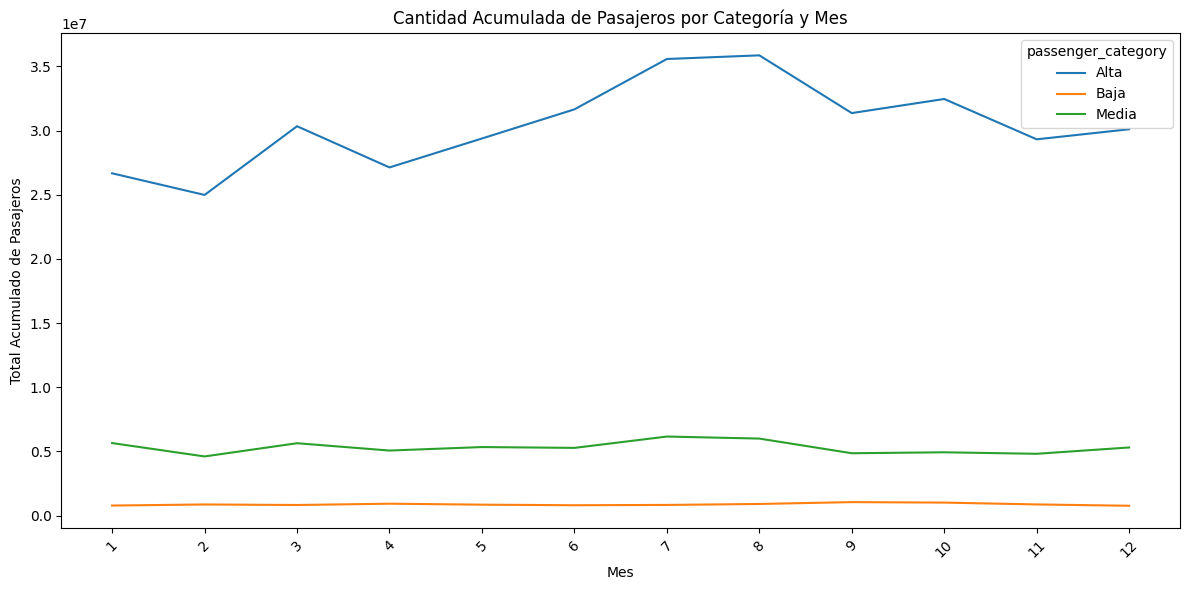

In [42]:
airline_monthly_passengers = datos_limpios.groupBy("Operating_Airline", "mes").agg(
    F.sum("Cantidad_pasajeros").alias("total_passengers")
)

# Paso 2: Categorizar las aerolíneas según la cantidad total de pasajeros
airline_monthly_passengers = airline_monthly_passengers.withColumn(
    "passenger_category",
    F.when(F.col("total_passengers") < 100000, "Baja")
    .when((F.col("total_passengers") >= 100000) & (F.col("total_passengers") <= 500000), "Media")
    .otherwise("Alta")
)

airline_monthly_passengers_pd = airline_monthly_passengers.toPandas()
# Calcular el total acumulado de pasajeros por mes y categoría
accumulated_passengers = airline_monthly_passengers_pd.groupby(['mes', 'passenger_category']).agg(
    {'total_passengers': 'sum'}).reset_index()

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 6))

# Crear el gráfico de líneas con acumulados (Cantidad Acumulada de Pasajeros por Categoría y Mes)
sns.lineplot(x="mes", y="total_passengers", hue="passenger_category", data=accumulated_passengers)

# Añadir título y etiquetas
plt.title('Cantidad Acumulada de Pasajeros por Categoría y Mes')
plt.xlabel('Mes')
plt.ylabel('Total Acumulado de Pasajeros')
plt.xticks(rotation=45)

plt.xticks(ticks=range(1, 13), labels=[str(i) for i in range(1, 13)])

# Mostrar el gráfico
plt.tight_layout()  # Ajusta los márgenes
plt.show()